In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
D001_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D001_data.csv')
D001_df = D001_df.iloc[913:]
D001_df = pd.DataFrame(D001_df)
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.index = D001_df['time']
D001_df = D001_df.drop(['time'],axis = 1)

In [5]:
def df_to_X_y(df,hoursToPredict, windowSize):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + windowSize)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+windowSize]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + windowSize ][0]
                y.append(label)
        return np.array(X), np.array(y)

In [6]:
def DataHandler(hoursToPredict,windowSize):
    X1, y1 = df_to_X_y(D001_df,hoursToPredict,windowSize)

    return X1, y1

In [7]:
plt.style.use('seaborn')

In [8]:
def Trainer(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        model = Sequential()
        model.add(InputLayer((windowSize, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,windowSize)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle= False) 

        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
        
        cp1= ModelCheckpoint(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/", save_best_only=True)
        model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.0001), 
                   metrics=[MeanAbsoluteError()])
    
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[cp1])
        windowSize += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

In [9]:
def modelsEvaluator(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        X, y = DataHandler(time,windowSize)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_Forecast/" + str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model = load_model(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        windowSize += 1

In [46]:
%%time

Trainer(1,6,9)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 5s 12ms/step - loss: 437.2867 - mean_absolute_error: 20.3856 - val_loss: 210.9870 - val_mean_absolute_error: 14.4063
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 6ms/step - loss: 296.1601 - mean_absolute_error: 16.6174 - val_loss: 104.4531 - val_mean_absolute_error: 9.9722
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 7ms/step - loss: 147.3714 - mean_absolute_error: 11.3527 - val_loss: 32.4391 - val_mean_absolute_error: 5.0821
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 6ms/step - loss: 64.3100 - mean_absolute_error: 6.8020 - val_loss: 8.1144 - val_mean_absolute_error: 2.2424
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 6ms/step - loss: 30.8843 - mean_absolute_error: 3.9625 - val_loss: 8.0279 - val_mean_absolute_error: 2.4518
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 6ms/step - loss: 19.4127 - mean_absolute_error: 2.8008 - val_loss: 12.2695 - val_mean_absolute_error: 3.0380
Epoch 7/25
161/161 [==============================] - 1s 6ms/step - loss: 16.1124 - mean_absolute_error: 2.6153 - val_loss: 14.1450 - val_mean_absolute_error: 3.2788
Epoch 8/25
161/161 [==============================] - 1s 6ms/step - loss: 14.6679 - mean_absolute_error: 2.5548 - val_loss: 14.8471 - val_mean_absolute_error: 3.3804
Epoch 9/25
161/161 [==============================] - 1s 7ms/step - loss: 13.3567 - mean_absolute_error: 2.4680 - val_loss: 13.6842 - val_mean_absolute_error: 3.2764
Epoch 10/25
161/161 [==============================] - 1s 7ms/step - loss: 12.0623 - mean_absolute_error: 2.3608 - val_loss: 13.8858 - val_mean_absolute_error: 3.2826
Epoch 11/25
161/161 [==============================] - 1s 7ms/step - loss: 11.2403 - mean_absolute_error: 2.3066 - val_loss: 14.5021 - val_mean_absolute_error: 3.3620
Ep

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 7ms/step - loss: 514.1086 - mean_absolute_error: 22.2160 - val_loss: 310.5338 - val_mean_absolute_error: 17.5844
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 7ms/step - loss: 499.2108 - mean_absolute_error: 21.8953 - val_loss: 283.9538 - val_mean_absolute_error: 16.7693
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 6ms/step - loss: 412.8747 - mean_absolute_error: 19.8290 - val_loss: 196.4530 - val_mean_absolute_error: 13.9120
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 9ms/step - loss: 292.0417 - mean_absolute_error: 16.4603 - val_loss: 110.6981 - val_mean_absolute_error: 10.3837
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 7ms/step - loss: 208.8953 - mean_absolute_error: 13.6955 - val_loss: 67.7567 - val_mean_absolute_error: 8.1386
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 156.7085 - mean_absolute_error: 11.6137 - val_loss: 36.2116 - val_mean_absolute_error: 5.8880
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 2s 12ms/step - loss: 114.6767 - mean_absolute_error: 9.6339 - val_loss: 18.9589 - val_mean_absolute_error: 4.1831
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 1s 9ms/step - loss: 84.5919 - mean_absolute_error: 7.9586 - val_loss: 7.7814 - val_mean_absolute_error: 2.5507
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
161/161 [==============================] - 1s 7ms/step - loss: 62.1910 - mean_absolute_error: 6.3963 - val_loss: 2.5147 - val_mean_absolute_error: 1.3386
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
161/161 [==============================] - 1s 6ms/step - loss: 47.7069 - mean_absolute_error: 5.1641 - val_loss: 1.3097 - val_mean_absolute_error: 0.8685
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
161/161 [==============================] - 1s 6ms/step - loss: 38.0092 - mean_absolute_error: 4.1889 - val_loss: 2.3004 - val_mean_absolute_error: 1.2206
Epoch 13/25
161/161 [==============================] - 1s 8ms/step - loss: 31.3624 - mean_absolute_error: 3.5001 - val_loss: 4.6952 - val_mean_absolute_error: 1.9008
Epoch 14/25
161/161 [==============================] - 1s 7ms/step - loss: 26.9760 - mean_absolute_error: 3.0862 - val_loss: 7.8154 - val_mean_absolute_error: 2.5670
Epoch 15/25
161/161 [==============================] - 1s 7ms/step - loss: 24.2586 - mean_absolute_error: 2.8795 - val_loss: 11.1191 - val_mean_absolute_error: 3.1350
Epoch 16/25
161/161 [==============================] - 1s 8ms/step - loss: 22.6913 - mean_absolute_error: 2.8586 - val_loss: 14.1010 - val_mean_absolute_error: 3.5770
Epoch 17/25
161/161 [==============================] - 1s 7ms/step - loss: 21.8722 - mean_absolute_error: 2.9310 - val_loss: 16.6816 - val_mean_absolute_error: 3.9205
E

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 7ms/step - loss: 441.0166 - mean_absolute_error: 20.4966 - val_loss: 233.5715 - val_mean_absolute_error: 15.2086
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - ETA: 0s - loss: 376.9587 - mean_absolute_error: 18.89 - 1s 7ms/step - loss: 376.9587 - mean_absolute_error: 18.8950 - val_loss: 185.7863 - val_mean_absolute_error: 13.5013
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 8ms/step - loss: 299.2822 - mean_absolute_error: 16.6847 - val_loss: 128.9013 - val_mean_absolute_error: 11.2349
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 7ms/step - loss: 231.5522 - mean_absolute_error: 14.5132 - val_loss: 80.8570 - val_mean_absolute_error: 8.8732
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 10ms/step - loss: 173.6920 - mean_absolute_error: 12.3653 - val_loss: 50.4444 - val_mean_absolute_error: 6.9862
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 7ms/step - loss: 135.8627 - mean_absolute_error: 10.7268 - val_loss: 31.1018 - val_mean_absolute_error: 5.4385
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 106.5242 - mean_absolute_error: 9.2638 - val_loss: 17.4439 - val_mean_absolute_error: 4.0029
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 1s 7ms/step - loss: 82.9380 - mean_absolute_error: 7.8895 - val_loss: 8.5779 - val_mean_absolute_error: 2.6774
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
161/161 [==============================] - 1s 8ms/step - loss: 64.4942 - mean_absolute_error: 6.6079 - val_loss: 3.6165 - val_mean_absolute_error: 1.6267
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
161/161 [==============================] - 1s 7ms/step - loss: 50.7695 - mean_absolute_error: 5.4771 - val_loss: 1.4989 - val_mean_absolute_error: 0.9614
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
161/161 [==============================] - 1s 8ms/step - loss: 40.6168 - mean_absolute_error: 4.4922 - val_loss: 1.7425 - val_mean_absolute_error: 1.0339
Epoch 13/25
161/161 [==============================] - 2s 10ms/step - loss: 33.3431 - mean_absolute_error: 3.7349 - val_loss: 3.5123 - val_mean_absolute_error: 1.5851
Epoch 14/25
161/161 [==============================] - 1s 9ms/step - loss: 28.3496 - mean_absolute_error: 3.2286 - val_loss: 6.1916 - val_mean_absolute_error: 2.2274
Epoch 15/25
161/161 [==============================] - 1s 8ms/step - loss: 25.0876 - mean_absolute_error: 2.9473 - val_loss: 9.2597 - val_mean_absolute_error: 2.8161
Epoch 16/25
161/161 [==============================] - 1s 9ms/step - loss: 23.0931 - mean_absolute_error: 2.8442 - val_loss: 12.2499 - val_mean_absolute_error: 3.2984
Epoch 17/25
161/161 [==============================] - 1s 9ms/step - loss: 21.9162 - mean_absolute_error: 2.8709 - val_loss: 15.0500 - val_mean_absolute_error: 3.6976
E

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 514.9761 - mean_absolute_error: 22.2395 - val_loss: 311.1569 - val_mean_absolute_error: 17.6018
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 509.6502 - mean_absolute_error: 22.1159 - val_loss: 304.1635 - val_mean_absolute_error: 17.4013
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 8ms/step - loss: 496.0323 - mean_absolute_error: 21.8023 - val_loss: 289.1118 - val_mean_absolute_error: 16.9621
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 8ms/step - loss: 473.0945 - mean_absolute_error: 21.2664 - val_loss: 266.0591 - val_mean_absolute_error: 16.2661
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 7ms/step - loss: 442.7709 - mean_absolute_error: 20.5308 - val_loss: 243.9700 - val_mean_absolute_error: 15.5736
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 412.3653 - mean_absolute_error: 19.7750 - val_loss: 219.7860 - val_mean_absolute_error: 14.7794
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 9ms/step - loss: 380.7270 - mean_absolute_error: 18.9737 - val_loss: 197.5552 - val_mean_absolute_error: 14.0069
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 1s 8ms/step - loss: 352.1154 - mean_absolute_error: 18.2006 - val_loss: 174.6913 - val_mean_absolute_error: 13.1666
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
161/161 [==============================] - 1s 8ms/step - loss: 322.6775 - mean_absolute_error: 17.3816 - val_loss: 155.1115 - val_mean_absolute_error: 12.3978
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
161/161 [==============================] - 1s 8ms/step - loss: 294.3049 - mean_absolute_error: 16.5440 - val_loss: 134.2015 - val_mean_absolute_error: 11.5249s: 297.8945 - mean_absol
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
161/161 [==============================] - 1s 8ms/step - loss: 268.4494 - mean_absolute_error: 15.7381 - val_loss: 116.9730 - val_mean_absolute_error: 10.7534
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
161/161 [==============================] - 1s 8ms/step - loss: 243.9883 - mean_absolute_error: 14.9425 - val_loss: 100.1278 - val_mean_absolute_error: 9.9398
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
161/161 [==============================] - 1s 7ms/step - loss: 219.2498 - mean_absolute_error: 14.0985 - val_loss: 83.7919 - val_mean_absolute_error: 9.0810
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
161/161 [==============================] - 2s 10ms/step - loss: 196.5877 - mean_absolute_error: 13.2692 - val_loss: 69.6616 - val_mean_absolute_error: 8.2656
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
161/161 [==============================] - 1s 8ms/step - loss: 175.6217 - mean_absolute_error: 12.4527 - val_loss: 56.7320 - val_mean_absolute_error: 7.4440
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
161/161 [==============================] - 1s 8ms/step - loss: 156.1973 - mean_absolute_error: 11.6453 - val_loss: 45.4676 - val_mean_absolute_error: 6.6449
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
161/161 [==============================] - 1s 9ms/step - loss: 138.3478 - mean_absolute_error: 10.8522 - val_loss: 35.5745 - val_mean_absolute_error: 5.8536
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
161/161 [==============================] - 1s 8ms/step - loss: 121.8799 - mean_absolute_error: 10.0616 - val_loss: 26.9810 - val_mean_absolute_error: 5.0671
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 20/25
161/161 [==============================] - 1s 8ms/step - loss: 106.2155 - mean_absolute_error: 9.2521 - val_loss: 19.1530 - val_mean_absolute_error: 4.2241
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 21/25
161/161 [==============================] - 1s 8ms/step - loss: 91.7706 - mean_absolute_error: 8.4353 - val_loss: 13.1835 - val_mean_absolute_error: 3.4457
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 22/25
161/161 [==============================] - 1s 8ms/step - loss: 79.4287 - mean_absolute_error: 7.6725 - val_loss: 8.5562 - val_mean_absolute_error: 2.6974
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 23/25
161/161 [==============================] - 1s 8ms/step - loss: 68.5531 - mean_absolute_error: 6.9252 - val_loss: 5.1405 - val_mean_absolute_error: 2.0150
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 24/25
161/161 [==============================] - 1s 8ms/step - loss: 59.0323 - mean_absolute_error: 6.1979 - val_loss: 2.8571 - val_mean_absolute_error: 1.4384
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


Epoch 25/25
161/161 [==============================] - 1s 8ms/step - loss: 50.8273 - mean_absolute_error: 5.5015 - val_loss: 1.6323 - val_mean_absolute_error: 1.0267
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

CPU times: total: 20min 19s
Wall time: 9min 49s


In [19]:
%%time

modelsEvaluator(1,6,9)

(5124, 6, 5) (5124,) (1708, 6, 5) (1708,) (1709, 6, 5) (1709,)
Loading: 1H_Forecast/1H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 2ms/step - loss: 16.5078 - mean_absolute_error: 2.9167
(5124, 7, 5) (5124,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 34.9960 - mean_absolute_error: 4.2376
(5123, 8, 5) (5123,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 35.4113 - mean_absolute_error: 4.3560
(5122, 9, 5) (5122,) (1708, 9, 5) (1708,) (1708, 9, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 5ms/step - loss: 35.5556 - mean_absolute_error: 4.4965
CPU times: total: 50.2 s
Wall time: 37.9 s


54/54 [==============================] - 1s 4ms/step - loss: 18.1551 - mean_absolute_error: 2.9650


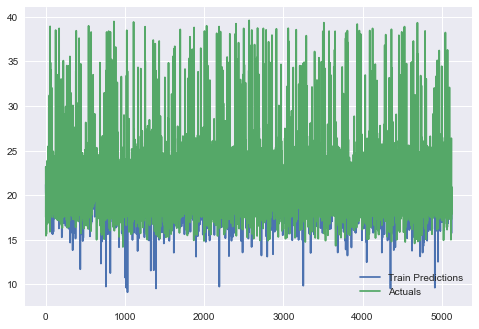

In [20]:
model = load_model('1H_Forecast/1H_ForecastModel_6_SizeWindow/')

X, y = DataHandler(1,6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 2 hours forecast

In [21]:
%%time

Trainer(2,6,9)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 4s 10ms/step - loss: 464.3888 - mean_absolute_error: 21.0997 - val_loss: 250.6724 - val_mean_absolute_error: 15.7573
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 7ms/step - loss: 382.4748 - mean_absolute_error: 19.0337 - val_loss: 179.3392 - val_mean_absolute_error: 13.2912
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 7ms/step - loss: 282.8047 - mean_absolute_error: 16.1915 - val_loss: 107.0323 - val_mean_absolute_error: 10.2021
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 7ms/step - loss: 185.9788 - mean_absolute_error: 12.8129 - val_loss: 47.5227 - val_mean_absolute_error: 6.6256
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 7ms/step - loss: 109.2516 - mean_absolute_error: 9.3168 - val_loss: 13.2626 - val_mean_absolute_error: 3.2961
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 7ms/step - loss: 64.6294 - mean_absolute_error: 6.5715 - val_loss: 3.2689 - val_mean_absolute_error: 1.4560
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 7ms/step - loss: 39.3982 - mean_absolute_error: 4.3270 - val_loss: 3.6155 - val_mean_absolute_error: 1.5322
Epoch 8/25
161/161 [==============================] - 1s 7ms/step - loss: 28.1269 - mean_absolute_error: 3.2256 - val_loss: 9.3987 - val_mean_absolute_error: 2.7507
Epoch 9/25
161/161 [==============================] - 1s 7ms/step - loss: 23.5204 - mean_absolute_error: 2.9198 - val_loss: 14.4588 - val_mean_absolute_error: 3.5526
Epoch 10/25
161/161 [==============================] - ETA: 0s - loss: 22.0154 - mean_absolute_error: 2.96 - 1s 8ms/step - loss: 21.9727 - mean_absolute_error: 2.9594 - val_loss: 17.1043 - val_mean_absolute_error: 3.8765
Epoch 11/25
161/161 [==============================] - 1s 8ms/step - loss: 20.9150 - mean_absolute_error: 2.9449 - val_loss: 17.1486 - val_mean_absolute_error: 3.8830
Epoch 12/25
161/161 [==============================] - 1s 8ms/step - loss: 19.8145 - mean_absolute_error: 2.8715 - v

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 9ms/step - loss: 295.3618 - mean_absolute_error: 16.3649 - val_loss: 91.3200 - val_mean_absolute_error: 9.3209
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 157.9919 - mean_absolute_error: 11.4632 - val_loss: 25.7638 - val_mean_absolute_error: 4.5148
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 9ms/step - loss: 66.7888 - mean_absolute_error: 6.5753 - val_loss: 5.2739 - val_mean_absolute_error: 1.9350
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 8ms/step - loss: 32.9290 - mean_absolute_error: 3.8203 - val_loss: 8.5722 - val_mean_absolute_error: 2.4360
Epoch 6/25
161/161 [==============================] - 1s 8ms/step - loss: 23.3207 - mean_absolute_error: 3.0296 - val_loss: 12.9827 - val_mean_absolute_error: 3.1204
Epoch 7/25
161/161 [==============================] - 1s 7ms/step - loss: 19.4396 - mean_absolute_error: 2.8180 - val_loss: 14.7337 - val_mean_absolute_error: 3.4649
Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 17.5589 - mean_absolute_error: 2.7135 - val_loss: 15.1363 - val_mean_absolute_error: 3.5958
Epoch 9/25
161/161 [==============================] - 1s 8ms/step - loss: 16.0380 - mean_absolute_error: 2.5753 - val_loss: 14.4849 - val_mean_absolute_error: 3.5007
Epoch 10/25
161/161 [==============================] - 2s 10ms/step - loss: 14.2341 - mean_absolute_error: 2.4464 - val_loss: 12.6007 - val_mean_absolute_error: 3.2793
Epo

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 393.6646 - mean_absolute_error: 19.2870 - val_loss: 178.0835 - val_mean_absolute_error: 13.2686
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 2s 14ms/step - loss: 272.1839 - mean_absolute_error: 15.7694 - val_loss: 87.0807 - val_mean_absolute_error: 9.1162
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 8ms/step - loss: 160.2989 - mean_absolute_error: 11.7008 - val_loss: 33.0949 - val_mean_absolute_error: 5.4073
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 8ms/step - loss: 90.4000 - mean_absolute_error: 8.2332 - val_loss: 7.0155 - val_mean_absolute_error: 2.2733
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 10ms/step - loss: 47.6219 - mean_absolute_error: 5.1634 - val_loss: 2.8355 - val_mean_absolute_error: 1.3750
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 28.0484 - mean_absolute_error: 3.3378 - val_loss: 8.9509 - val_mean_absolute_error: 2.6014
Epoch 8/25
161/161 [==============================] - 2s 10ms/step - loss: 20.5600 - mean_absolute_error: 2.7643 - val_loss: 13.3405 - val_mean_absolute_error: 3.3412
Epoch 9/25
161/161 [==============================] - 2s 14ms/step - loss: 18.0488 - mean_absolute_error: 2.6229 - val_loss: 12.3318 - val_mean_absolute_error: 3.2757
Epoch 10/25
161/161 [==============================] - 1s 9ms/step - loss: 15.9867 - mean_absolute_error: 2.4947 - val_loss: 13.7920 - val_mean_absolute_error: 3.4636
Epoch 11/25
161/161 [==============================] - 2s 13ms/step - loss: 14.1473 - mean_absolute_error: 2.3489 - val_loss: 14.4531 - val_mean_absolute_error: 3.5563
Epoch 12/25
161/161 [==============================] - 2s 12ms/step - loss: 13.0544 - mean_absolute_error: 2.2886 - val_loss: 14.5045 - val_mean_absolute_error: 3.561

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 2s 13ms/step - loss: 506.8086 - mean_absolute_error: 22.0551 - val_loss: 301.9395 - val_mean_absolute_error: 17.3349
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 2s 10ms/step - loss: 492.1248 - mean_absolute_error: 21.7227 - val_loss: 289.1643 - val_mean_absolute_error: 16.9594
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 9ms/step - loss: 468.5353 - mean_absolute_error: 21.1684 - val_loss: 264.7228 - val_mean_absolute_error: 16.2245
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 2s 11ms/step - loss: 437.0177 - mean_absolute_error: 20.4083 - val_loss: 239.0723 - val_mean_absolute_error: 15.4148
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 9ms/step - loss: 397.4402 - mean_absolute_error: 19.4148 - val_loss: 203.1021 - val_mean_absolute_error: 14.2012
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 2s 10ms/step - loss: 351.3586 - mean_absolute_error: 18.1790 - val_loss: 170.8035 - val_mean_absolute_error: 13.0151
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 2s 12ms/step - loss: 306.6785 - mean_absolute_error: 16.9170 - val_loss: 138.7422 - val_mean_absolute_error: 11.7121
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 2s 12ms/step - loss: 264.1783 - mean_absolute_error: 15.6197 - val_loss: 109.7027 - val_mean_absolute_error: 10.4045
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
161/161 [==============================] - 2s 12ms/step - loss: 224.4975 - mean_absolute_error: 14.2793 - val_loss: 83.4778 - val_mean_absolute_error: 9.0603
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
161/161 [==============================] - 2s 11ms/step - loss: 190.1964 - mean_absolute_error: 13.0249 - val_loss: 62.4857 - val_mean_absolute_error: 7.8158
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
161/161 [==============================] - 2s 11ms/step - loss: 159.8503 - mean_absolute_error: 11.7990 - val_loss: 44.2305 - val_mean_absolute_error: 6.5477
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 13/25
161/161 [==============================] - 2s 12ms/step - loss: 129.8512 - mean_absolute_error: 10.4441 - val_loss: 28.2405 - val_mean_absolute_error: 5.1807
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 14/25
161/161 [==============================] - 2s 10ms/step - loss: 104.7522 - mean_absolute_error: 9.1682 - val_loss: 17.2510 - val_mean_absolute_error: 3.9892
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 15/25
161/161 [==============================] - 2s 10ms/step - loss: 85.2804 - mean_absolute_error: 8.0372 - val_loss: 9.5645 - val_mean_absolute_error: 2.8764
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 16/25
161/161 [==============================] - 2s 13ms/step - loss: 69.2904 - mean_absolute_error: 6.9663 - val_loss: 4.6059 - val_mean_absolute_error: 1.8960
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 17/25
161/161 [==============================] - 2s 11ms/step - loss: 56.2200 - mean_absolute_error: 5.9486 - val_loss: 1.9471 - val_mean_absolute_error: 1.1540
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 18/25
161/161 [==============================] - 2s 11ms/step - loss: 45.9184 - mean_absolute_error: 5.0043 - val_loss: 1.2522 - val_mean_absolute_error: 0.8436
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow\assets


Epoch 19/25
161/161 [==============================] - 2s 12ms/step - loss: 37.9963 - mean_absolute_error: 4.1918 - val_loss: 2.1219 - val_mean_absolute_error: 1.1679
Epoch 20/25
161/161 [==============================] - 2s 14ms/step - loss: 32.1789 - mean_absolute_error: 3.5744 - val_loss: 4.0579 - val_mean_absolute_error: 1.7476
Epoch 21/25
161/161 [==============================] - 2s 13ms/step - loss: 28.1135 - mean_absolute_error: 3.1861 - val_loss: 6.6394 - val_mean_absolute_error: 2.3417
Epoch 22/25
161/161 [==============================] - 2s 11ms/step - loss: 25.3539 - mean_absolute_error: 2.9453 - val_loss: 9.4915 - val_mean_absolute_error: 2.8724
Epoch 23/25
161/161 [==============================] - 2s 11ms/step - loss: 23.5577 - mean_absolute_error: 2.8585 - val_loss: 12.3194 - val_mean_absolute_error: 3.3221
Epoch 24/25
161/161 [==============================] - 2s 14ms/step - loss: 22.5026 - mean_absolute_error: 2.8845 - val_loss: 14.7860 - val_mean_absolute_error: 3.6

In [24]:
%%time

modelsEvaluator(2,6,9)

(5124, 6, 5) (5124,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 36.1770 - mean_absolute_error: 4.6566
(5123, 7, 5) (5123,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 5ms/step - loss: 32.2846 - mean_absolute_error: 4.3210
(5122, 8, 5) (5122,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 23.7999 - mean_absolute_error: 3.4242
(5121, 9, 5) (5121,) (1708, 9, 5) (1708,) (1708, 9, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 31.5425 - mean_absolute_error: 4.0255
CPU times: total: 55 s
Wall time: 44.4 s


54/54 [==============================] - 1s 3ms/step - loss: 27.3637 - mean_absolute_error: 3.7232


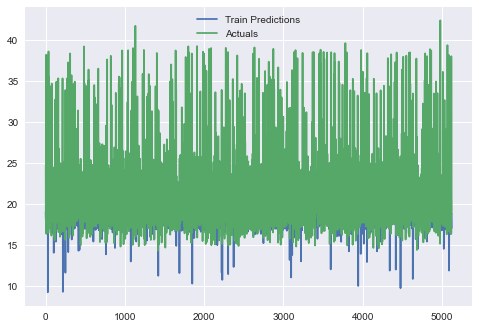

In [25]:
model = load_model('2H_Forecast/2H_ForecastModel_8_SizeWindow/')

X, y = DataHandler(2,8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 3 hours forecast

In [26]:
%%time

Trainer(3,6,9)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 4s 11ms/step - loss: 469.9772 - mean_absolute_error: 21.1322 - val_loss: 238.9371 - val_mean_absolute_error: 15.4003
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 382.1448 - mean_absolute_error: 18.9495 - val_loss: 174.8304 - val_mean_absolute_error: 13.1426
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 7ms/step - loss: 287.3120 - mean_absolute_error: 16.2921 - val_loss: 109.0080 - val_mean_absolute_error: 10.2872
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 7ms/step - loss: 190.6573 - mean_absolute_error: 12.9370 - val_loss: 50.9935 - val_mean_absolute_error: 6.9542
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 6ms/step - loss: 127.6312 - mean_absolute_error: 10.2511 - val_loss: 21.4297 - val_mean_absolute_error: 4.3486
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 7ms/step - loss: 83.1082 - mean_absolute_error: 7.6967 - val_loss: 5.7236 - val_mean_absolute_error: 2.0836
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 7ms/step - loss: 58.6531 - mean_absolute_error: 5.8995 - val_loss: 1.6671 - val_mean_absolute_error: 1.0313
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 40.7899 - mean_absolute_error: 4.3912 - val_loss: 3.0521 - val_mean_absolute_error: 1.4099
Epoch 9/25
161/161 [==============================] - 2s 10ms/step - loss: 29.0105 - mean_absolute_error: 3.2651 - val_loss: 7.2639 - val_mean_absolute_error: 2.4217
Epoch 10/25
161/161 [==============================] - 2s 10ms/step - loss: 24.1603 - mean_absolute_error: 2.9012 - val_loss: 11.3212 - val_mean_absolute_error: 3.1355
Epoch 11/25
161/161 [==============================] - 2s 9ms/step - loss: 21.6496 - mean_absolute_error: 2.8438 - val_loss: 14.0610 - val_mean_absolute_error: 3.5461
Epoch 12/25
161/161 [==============================] - 2s 9ms/step - loss: 20.4426 - mean_absolute_error: 2.8567 - val_loss: 15.4090 - val_mean_absolute_error: 3.7017
Epoch 13/25
161/161 [==============================] - 2s 9ms/step - loss: 19.4832 - mean_absolute_error: 2.8235 - val_loss: 15.8553 - val_mean_absolute_error: 3.7790


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 286.8936 - mean_absolute_error: 16.0595 - val_loss: 84.9381 - val_mean_absolute_error: 8.9310
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 150.7575 - mean_absolute_error: 11.0893 - val_loss: 25.8624 - val_mean_absolute_error: 4.3170
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 10ms/step - loss: 64.3932 - mean_absolute_error: 6.3044 - val_loss: 8.4267 - val_mean_absolute_error: 2.5076
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 9ms/step - loss: 28.9966 - mean_absolute_error: 3.5500 - val_loss: 12.4429 - val_mean_absolute_error: 2.9018
Epoch 6/25
161/161 [==============================] - 1s 8ms/step - loss: 20.7797 - mean_absolute_error: 2.9994 - val_loss: 15.9173 - val_mean_absolute_error: 3.3819
Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 18.4660 - mean_absolute_error: 2.8578 - val_loss: 17.3764 - val_mean_absolute_error: 3.6058
Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 17.1581 - mean_absolute_error: 2.7861 - val_loss: 18.0091 - val_mean_absolute_error: 3.7253
Epoch 9/25
161/161 [==============================] - 1s 8ms/step - loss: 15.9456 - mean_absolute_error: 2.6557 - val_loss: 16.2709 - val_mean_absolute_error: 3.5622
Epoch 10/25
161/161 [==============================] - 1s 8ms/step - loss: 14.8889 - mean_absolute_error: 2.5642 - val_loss: 15.8235 - val_mean_absolute_error: 3.5790
Epo

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 23/25
161/161 [==============================] - 1s 8ms/step - loss: 4.4285 - mean_absolute_error: 1.4758 - val_loss: 6.1344 - val_mean_absolute_error: 2.1779
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
161/161 [==============================] - 2s 10ms/step - loss: 3.6483 - mean_absolute_error: 1.2949 - val_loss: 5.7279 - val_mean_absolute_error: 2.1149
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


Epoch 25/25
161/161 [==============================] - 1s 8ms/step - loss: 3.1772 - mean_absolute_error: 1.1844 - val_loss: 5.1927 - val_mean_absolute_error: 2.0151
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow\assets



-----------------------------------------------------------------------------------------------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 5s 12ms/step - loss: 484.4489 - mean_absolute_error: 21.5311 - val_loss: 271.1203 - val_mean_absolute_error: 16.4207
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 424.4962 - mean_absolute_error: 20.1553 - val_loss: 221.0067 - val_mean_absolute_error: 14.7664
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 316.7781 - mean_absolute_error: 17.2550 - val_loss: 127.9782 - val_mean_absolute_error: 11.0627
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 11ms/step - loss: 186.9457 - mean_absolute_error: 12.8043 - val_loss: 43.7579 - val_mean_absolute_error: 6.2169
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 3s 18ms/step - loss: 101.4891 - mean_absolute_error: 8.8067 - val_loss: 10.0814 - val_mean_absolute_error: 2.7480
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 9ms/step - loss: 60.4312 - mean_absolute_error: 6.0824 - val_loss: 2.3543 - val_mean_absolute_error: 1.2209
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 9ms/step - loss: 38.4978 - mean_absolute_error: 4.1616 - val_loss: 5.1996 - val_mean_absolute_error: 1.8741
Epoch 8/25
161/161 [==============================] - 2s 9ms/step - loss: 26.8854 - mean_absolute_error: 3.1122 - val_loss: 11.1941 - val_mean_absolute_error: 3.0244
Epoch 9/25
161/161 [==============================] - 2s 10ms/step - loss: 23.0896 - mean_absolute_error: 2.9643 - val_loss: 15.7936 - val_mean_absolute_error: 3.7006
Epoch 10/25
161/161 [==============================] - 1s 9ms/step - loss: 21.4566 - mean_absolute_error: 3.0253 - val_loss: 18.3120 - val_mean_absolute_error: 3.9995
Epoch 11/25
161/161 [==============================] - 2s 10ms/step - loss: 20.8811 - mean_absolute_error: 3.0495 - val_loss: 18.7445 - val_mean_absolute_error: 4.0366
Epoch 12/25
161/161 [==============================] - 1s 9ms/step - loss: 20.2267 - mean_absolute_error: 3.0020 - val_loss: 19.1716 - val_mean_absolute_error: 4.0935


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 9ms/step - loss: 475.0647 - mean_absolute_error: 21.3129 - val_loss: 266.3465 - val_mean_absolute_error: 16.2764
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 2s 9ms/step - loss: 430.5993 - mean_absolute_error: 20.2562 - val_loss: 228.8718 - val_mean_absolute_error: 15.0619
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 10ms/step - loss: 361.9079 - mean_absolute_error: 18.4509 - val_loss: 168.0860 - val_mean_absolute_error: 12.8669
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 2s 10ms/step - loss: 285.1642 - mean_absolute_error: 16.2410 - val_loss: 118.0483 - val_mean_absolute_error: 10.7564
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 10ms/step - loss: 220.6286 - mean_absolute_error: 14.1164 - val_loss: 74.6197 - val_mean_absolute_error: 8.5291
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 9ms/step - loss: 161.3453 - mean_absolute_error: 11.8241 - val_loss: 39.7800 - val_mean_absolute_error: 6.1471
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 2s 10ms/step - loss: 113.2635 - mean_absolute_error: 9.6027 - val_loss: 18.8422 - val_mean_absolute_error: 4.0910
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 2s 10ms/step - loss: 77.8609 - mean_absolute_error: 7.5457 - val_loss: 6.1131 - val_mean_absolute_error: 2.1260
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
161/161 [==============================] - 1s 9ms/step - loss: 51.3681 - mean_absolute_error: 5.4682 - val_loss: 2.1200 - val_mean_absolute_error: 1.1902
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
161/161 [==============================] - 2s 11ms/step - loss: 34.9700 - mean_absolute_error: 3.8813 - val_loss: 4.6067 - val_mean_absolute_error: 1.7590
Epoch 12/25
161/161 [==============================] - 2s 13ms/step - loss: 27.6253 - mean_absolute_error: 3.1558 - val_loss: 8.9653 - val_mean_absolute_error: 2.6799
Epoch 13/25
161/161 [==============================] - 2s 13ms/step - loss: 24.1081 - mean_absolute_error: 2.9211 - val_loss: 13.1283 - val_mean_absolute_error: 3.3513
Epoch 14/25
161/161 [==============================] - 2s 13ms/step - loss: 21.9769 - mean_absolute_error: 2.9176 - val_loss: 16.2572 - val_mean_absolute_error: 3.7747
Epoch 15/25
161/161 [==============================] - 2s 13ms/step - loss: 21.0310 - mean_absolute_error: 2.9781 - val_loss: 18.0945 - val_mean_absolute_error: 4.0009
Epoch 16/25
161/161 [==============================] - 2s 13ms/step - loss: 20.0211 - mean_absolute_error: 2.9363 - val_loss: 17.6422 - val_mean_absolute_error: 3

In [27]:
%%time

modelsEvaluator(3,6,9)

(5123, 6, 5) (5123,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 37.4940 - mean_absolute_error: 4.4903
(5122, 7, 5) (5122,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 2ms/step - loss: 2.9168 - mean_absolute_error: 1.2485
(5121, 8, 5) (5121,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 33.7315 - mean_absolute_error: 4.2990
(5121, 9, 5) (5121,) (1707, 9, 5) (1707,) (1708, 9, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 31.3845 - mean_absolute_error: 4.0533
CPU times: total: 52.9 s
Wall time: 40.1 s


54/54 [==============================] - 1s 3ms/step - loss: 2.9256 - mean_absolute_error: 1.2706


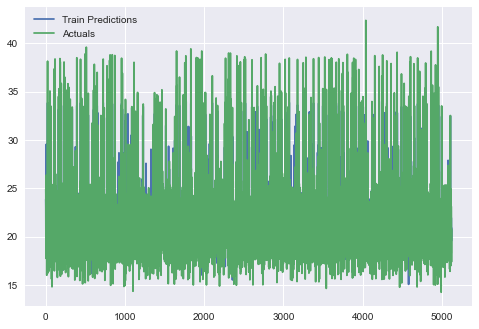

In [34]:
model = load_model('3H_Forecast/3H_ForecastModel_7_SizeWindow/')

X, y = DataHandler(3,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 4 hours forecast

In [28]:
%%time

Trainer(4,6,9)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 5s 12ms/step - loss: 472.2898 - mean_absolute_error: 21.2103 - val_loss: 250.6585 - val_mean_absolute_error: 15.7819
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 9ms/step - loss: 412.4733 - mean_absolute_error: 19.7376 - val_loss: 199.8701 - val_mean_absolute_error: 14.0665
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 7ms/step - loss: 305.0527 - mean_absolute_error: 16.7729 - val_loss: 106.1545 - val_mean_absolute_error: 10.1293
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 7ms/step - loss: 183.5977 - mean_absolute_error: 12.6357 - val_loss: 38.4272 - val_mean_absolute_error: 5.9148
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 8ms/step - loss: 100.8364 - mean_absolute_error: 8.8084 - val_loss: 11.8638 - val_mean_absolute_error: 2.9240
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 10ms/step - loss: 58.5179 - mean_absolute_error: 5.9513 - val_loss: 2.9649 - val_mean_absolute_error: 1.3346
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 7ms/step - loss: 38.9251 - mean_absolute_error: 4.1707 - val_loss: 3.8726 - val_mean_absolute_error: 1.6985
Epoch 8/25
161/161 [==============================] - 1s 7ms/step - loss: 29.4474 - mean_absolute_error: 3.2663 - val_loss: 8.9000 - val_mean_absolute_error: 2.6708
Epoch 9/25
161/161 [==============================] - 1s 7ms/step - loss: 25.2144 - mean_absolute_error: 2.9981 - val_loss: 13.2850 - val_mean_absolute_error: 3.3427
Epoch 10/25
161/161 [==============================] - 1s 9ms/step - loss: 23.4000 - mean_absolute_error: 3.0210 - val_loss: 16.0515 - val_mean_absolute_error: 3.7322
Epoch 11/25
161/161 [==============================] - 1s 9ms/step - loss: 22.1887 - mean_absolute_error: 3.0379 - val_loss: 17.2465 - val_mean_absolute_error: 3.9096
Epoch 12/25
161/161 [==============================] - 1s 9ms/step - loss: 21.1388 - mean_absolute_error: 3.0095 - val_loss: 17.8068 - val_mean_absolute_error: 3.9730
Epo

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 375.5769 - mean_absolute_error: 18.8467 - val_loss: 180.4824 - val_mean_absolute_error: 13.3445
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 280.9795 - mean_absolute_error: 16.1480 - val_loss: 110.1963 - val_mean_absolute_error: 10.3218
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 8ms/step - loss: 195.9297 - mean_absolute_error: 13.1938 - val_loss: 58.2607 - val_mean_absolute_error: 7.4034
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 8ms/step - loss: 133.8109 - mean_absolute_error: 10.5464 - val_loss: 26.7373 - val_mean_absolute_error: 4.8986
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 8ms/step - loss: 87.7571 - mean_absolute_error: 8.1030 - val_loss: 8.7853 - val_mean_absolute_error: 2.5487
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 9ms/step - loss: 55.4453 - mean_absolute_error: 5.7751 - val_loss: 2.2820 - val_mean_absolute_error: 1.1822
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 9ms/step - loss: 38.4238 - mean_absolute_error: 4.2027 - val_loss: 3.1175 - val_mean_absolute_error: 1.4590
Epoch 9/25
161/161 [==============================] - 1s 9ms/step - loss: 29.5937 - mean_absolute_error: 3.3096 - val_loss: 7.3096 - val_mean_absolute_error: 2.3791
Epoch 10/25
161/161 [==============================] - 1s 8ms/step - loss: 25.0516 - mean_absolute_error: 2.9549 - val_loss: 11.9174 - val_mean_absolute_error: 3.2007
Epoch 11/25
161/161 [==============================] - 1s 8ms/step - loss: 22.6277 - mean_absolute_error: 2.9263 - val_loss: 15.8369 - val_mean_absolute_error: 3.7718
Epoch 12/25
161/161 [==============================] - 1s 9ms/step - loss: 21.6477 - mean_absolute_error: 3.0067 - val_loss: 18.0196 - val_mean_absolute_error: 4.0444
Epoch 13/25
161/161 [==============================] - 1s 9ms/step - loss: 20.8354 - mean_absolute_error: 3.0321 - val_loss: 18.4710 - val_mean_absolute_error: 4.0892
Ep

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 9ms/step - loss: 348.8823 - mean_absolute_error: 18.1380 - val_loss: 131.1046 - val_mean_absolute_error: 11.2691
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 9ms/step - loss: 160.3623 - mean_absolute_error: 11.6230 - val_loss: 22.0330 - val_mean_absolute_error: 3.8799
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 9ms/step - loss: 46.1837 - mean_absolute_error: 5.1742 - val_loss: 8.0663 - val_mean_absolute_error: 2.3337
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 7ms/step - loss: 21.5837 - mean_absolute_error: 3.0918 - val_loss: 12.2444 - val_mean_absolute_error: 2.8671
Epoch 6/25
161/161 [==============================] - 2s 11ms/step - loss: 16.1664 - mean_absolute_error: 2.6403 - val_loss: 14.0077 - val_mean_absolute_error: 3.2986
Epoch 7/25
161/161 [==============================] - 2s 11ms/step - loss: 13.9858 - mean_absolute_error: 2.4838 - val_loss: 14.5926 - val_mean_absolute_error: 3.4533
Epoch 8/25
161/161 [==============================] - 2s 11ms/step - loss: 12.7667 - mean_absolute_error: 2.4077 - val_loss: 14.8080 - val_mean_absolute_error: 3.5237
Epoch 9/25
161/161 [==============================] - 2s 12ms/step - loss: 11.7726 - mean_absolute_error: 2.3425 - val_loss: 14.7119 - val_mean_absolute_error: 3.5290
Epoch 10/25
161/161 [==============================] - 2s 11ms/step - loss: 10.8589 - mean_absolute_error: 2.2915 - val_loss: 14.7219 - val_mean_absolute_error: 3.551

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 23/25
161/161 [==============================] - 2s 10ms/step - loss: 3.4301 - mean_absolute_error: 1.3580 - val_loss: 7.5772 - val_mean_absolute_error: 2.5615
Epoch 24/25
161/161 [==============================] - 1s 9ms/step - loss: 3.1291 - mean_absolute_error: 1.2878 - val_loss: 6.6019 - val_mean_absolute_error: 2.3732
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow\assets


Epoch 25/25
161/161 [==============================] - 1s 9ms/step - loss: 2.8668 - mean_absolute_error: 1.2174 - val_loss: 6.6976 - val_mean_absolute_error: 2.4226

-----------------------------------------------------------------------------------------------------------

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 5s 13ms/step - loss: 473.0721 - mean_absolute_erro

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 2s 9ms/step - loss: 366.8289 - mean_absolute_error: 18.4614 - val_loss: 146.5284 - val_mean_absolute_error: 11.9466
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 9ms/step - loss: 219.5998 - mean_absolute_error: 13.9364 - val_loss: 57.0578 - val_mean_absolute_error: 7.2500
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 9ms/step - loss: 120.8792 - mean_absolute_error: 9.8017 - val_loss: 15.9938 - val_mean_absolute_error: 3.3413
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 2s 10ms/step - loss: 60.5252 - mean_absolute_error: 5.9905 - val_loss: 3.5207 - val_mean_absolute_error: 1.4514
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 9ms/step - loss: 35.8839 - mean_absolute_error: 3.8601 - val_loss: 7.3692 - val_mean_absolute_error: 2.3746
Epoch 7/25
161/161 [==============================] - 2s 10ms/step - loss: 25.7014 - mean_absolute_error: 3.0265 - val_loss: 12.5407 - val_mean_absolute_error: 3.1872
Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 21.7514 - mean_absolute_error: 2.9027 - val_loss: 15.4420 - val_mean_absolute_error: 3.6108
Epoch 9/25
161/161 [==============================] - 2s 11ms/step - loss: 19.7157 - mean_absolute_error: 2.8552 - val_loss: 16.2375 - val_mean_absolute_error: 3.7367
Epoch 10/25
161/161 [==============================] - 2s 13ms/step - loss: 18.2844 - mean_absolute_error: 2.8008 - val_loss: 17.3293 - val_mean_absolute_error: 3.8782
Epoch 11/25
161/161 [==============================] - 2s 13ms/step - loss: 17.1153 - mean_absolute_error: 2.7489 - val_loss: 17.9104 - val_mean_absolute_error: 3.9591

In [29]:
%%time

modelsEvaluator(4,6,9)

(5122, 6, 5) (5122,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 36.3965 - mean_absolute_error: 4.4325
(5121, 7, 5) (5121,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 37.2642 - mean_absolute_error: 4.3809
(5121, 8, 5) (5121,) (1707, 8, 5) (1707,) (1708, 8, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 3.8330 - mean_absolute_error: 1.5154
(5121, 9, 5) (5121,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 33.2236 - mean_absolute_error: 4.2060
CPU times: total: 56.7 s
Wall time: 44.2 s


54/54 [==============================] - 1s 3ms/step - loss: 3.8335 - mean_absolute_error: 1.5507


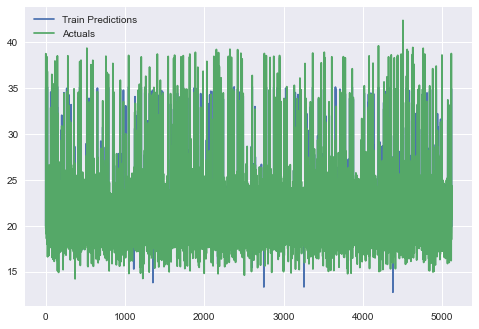

In [36]:
model = load_model('4H_Forecast/4H_ForecastModel_8_SizeWindow/')

X, y = DataHandler(4,8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 5 hours forecast

In [30]:
%%time

Trainer(5,6,9)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 4s 12ms/step - loss: 476.9778 - mean_absolute_error: 21.3373 - val_loss: 255.2868 - val_mean_absolute_error: 15.9355
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 7ms/step - loss: 411.0887 - mean_absolute_error: 19.7024 - val_loss: 191.3460 - val_mean_absolute_error: 13.7615
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 307.4568 - mean_absolute_error: 16.8338 - val_loss: 114.0628 - val_mean_absolute_error: 10.5527
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 7ms/step - loss: 206.4135 - mean_absolute_error: 13.5603 - val_loss: 58.6851 - val_mean_absolute_error: 7.4762
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 7ms/step - loss: 127.9514 - mean_absolute_error: 10.2564 - val_loss: 20.1431 - val_mean_absolute_error: 4.2321
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 7ms/step - loss: 76.9378 - mean_absolute_error: 7.4313 - val_loss: 5.2308 - val_mean_absolute_error: 1.9572
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 49.6186 - mean_absolute_error: 5.3752 - val_loss: 1.5754 - val_mean_absolute_error: 0.9869
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 7ms/step - loss: 34.1616 - mean_absolute_error: 3.8488 - val_loss: 4.6230 - val_mean_absolute_error: 1.8042
Epoch 9/25
161/161 [==============================] - 1s 7ms/step - loss: 24.9213 - mean_absolute_error: 2.9922 - val_loss: 10.3215 - val_mean_absolute_error: 2.9395
Epoch 10/25
161/161 [==============================] - 1s 8ms/step - loss: 21.7973 - mean_absolute_error: 2.8262 - val_loss: 14.0672 - val_mean_absolute_error: 3.5014
Epoch 11/25
161/161 [==============================] - 1s 8ms/step - loss: 20.4623 - mean_absolute_error: 2.8533 - val_loss: 16.2725 - val_mean_absolute_error: 3.8017
Epoch 12/25
161/161 [==============================] - 1s 8ms/step - loss: 19.1501 - mean_absolute_error: 2.8675 - val_loss: 17.8449 - val_mean_absolute_error: 3.9873
Epoch 13/25
161/161 [==============================] - 1s 8ms/step - loss: 18.0079 - mean_absolute_error: 2.8387 - val_loss: 18.3549 - val_mean_absolute_error: 4.0676
E

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 458.4328 - mean_absolute_error: 20.9056 - val_loss: 251.8208 - val_mean_absolute_error: 15.8157
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 406.2024 - mean_absolute_error: 19.6112 - val_loss: 201.3241 - val_mean_absolute_error: 14.1130
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 7ms/step - loss: 344.9466 - mean_absolute_error: 17.9831 - val_loss: 162.5187 - val_mean_absolute_error: 12.6667
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 8ms/step - loss: 287.4666 - mean_absolute_error: 16.3108 - val_loss: 123.0474 - val_mean_absolute_error: 11.0014
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 8ms/step - loss: 240.3430 - mean_absolute_error: 14.8086 - val_loss: 91.4058 - val_mean_absolute_error: 9.4782
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 198.7808 - mean_absolute_error: 13.3453 - val_loss: 67.0855 - val_mean_absolute_error: 8.0962
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 162.3876 - mean_absolute_error: 11.9036 - val_loss: 45.2306 - val_mean_absolute_error: 6.6181
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 1s 8ms/step - loss: 132.8562 - mean_absolute_error: 10.5901 - val_loss: 30.2932 - val_mean_absolute_error: 5.3815
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 10/25
161/161 [==============================] - 1s 8ms/step - loss: 108.7184 - mean_absolute_error: 9.3875 - val_loss: 18.8465 - val_mean_absolute_error: 4.1872
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 11/25
161/161 [==============================] - 1s 8ms/step - loss: 88.5389 - mean_absolute_error: 8.2479 - val_loss: 10.9163 - val_mean_absolute_error: 3.1000
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 12/25
161/161 [==============================] - 1s 9ms/step - loss: 71.8695 - mean_absolute_error: 7.1554 - val_loss: 5.2808 - val_mean_absolute_error: 2.0474
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 13/25
161/161 [==============================] - 1s 8ms/step - loss: 57.5589 - mean_absolute_error: 6.0754 - val_loss: 2.2505 - val_mean_absolute_error: 1.2542
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
161/161 [==============================] - 2s 9ms/step - loss: 46.5762 - mean_absolute_error: 5.0959 - val_loss: 1.3229 - val_mean_absolute_error: 0.8759
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
161/161 [==============================] - 1s 9ms/step - loss: 38.3428 - mean_absolute_error: 4.2645 - val_loss: 1.9793 - val_mean_absolute_error: 1.1098
Epoch 16/25
161/161 [==============================] - 1s 9ms/step - loss: 32.2951 - mean_absolute_error: 3.6350 - val_loss: 3.7517 - val_mean_absolute_error: 1.6575
Epoch 17/25
161/161 [==============================] - 1s 8ms/step - loss: 28.0141 - mean_absolute_error: 3.2064 - val_loss: 6.2150 - val_mean_absolute_error: 2.2451
Epoch 18/25
161/161 [==============================] - 1s 8ms/step - loss: 25.0880 - mean_absolute_error: 2.9565 - val_loss: 8.9754 - val_mean_absolute_error: 2.7768
Epoch 19/25
161/161 [==============================] - 1s 8ms/step - loss: 23.1623 - mean_absolute_error: 2.8393 - val_loss: 11.8307 - val_mean_absolute_error: 3.2438
Epoch 20/25
161/161 [==============================] - 1s 8ms/step - loss: 22.0102 - mean_absolute_error: 2.8443 - val_loss: 14.3693 - val_mean_absolute_error: 3.6129
Ep

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 408.2385 - mean_absolute_error: 19.6753 - val_loss: 197.5061 - val_mean_absolute_error: 13.9016
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 9ms/step - loss: 300.4275 - mean_absolute_error: 16.6796 - val_loss: 120.3469 - val_mean_absolute_error: 10.6579
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 2s 10ms/step - loss: 195.3770 - mean_absolute_error: 13.0801 - val_loss: 53.5673 - val_mean_absolute_error: 6.8899
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 9ms/step - loss: 119.4760 - mean_absolute_error: 9.7723 - val_loss: 20.2657 - val_mean_absolute_error: 3.9911
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 2s 10ms/step - loss: 75.5056 - mean_absolute_error: 7.2133 - val_loss: 5.2941 - val_mean_absolute_error: 1.8959
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 2s 10ms/step - loss: 47.1560 - mean_absolute_error: 4.9646 - val_loss: 2.5360 - val_mean_absolute_error: 1.2823
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 9ms/step - loss: 32.1161 - mean_absolute_error: 3.5319 - val_loss: 6.0132 - val_mean_absolute_error: 2.1338
Epoch 9/25
161/161 [==============================] - 2s 10ms/step - loss: 25.5815 - mean_absolute_error: 2.9853 - val_loss: 10.2400 - val_mean_absolute_error: 2.9351
Epoch 10/25
161/161 [==============================] - 1s 9ms/step - loss: 22.2166 - mean_absolute_error: 2.8314 - val_loss: 13.7496 - val_mean_absolute_error: 3.4764
Epoch 11/25
161/161 [==============================] - 1s 9ms/step - loss: 20.4537 - mean_absolute_error: 2.8362 - val_loss: 15.7819 - val_mean_absolute_error: 3.7594
Epoch 12/25
161/161 [==============================] - 1s 9ms/step - loss: 19.3840 - mean_absolute_error: 2.8037 - val_loss: 15.2927 - val_mean_absolute_error: 3.7036
Epoch 13/25
161/161 [==============================] - 1s 9ms/step - loss: 18.4159 - mean_absolute_error: 2.7561 - val_loss: 16.7080 - val_mean_absolute_error: 3.8775


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
160/160 [==============================] - 1s 8ms/step - loss: 403.6064 - mean_absolute_error: 19.6155 - val_loss: 208.4996 - val_mean_absolute_error: 14.3652
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
160/160 [==============================] - 1s 8ms/step - loss: 311.9162 - mean_absolute_error: 17.1513 - val_loss: 135.5020 - val_mean_absolute_error: 11.5133
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
160/160 [==============================] - 1s 9ms/step - loss: 213.0496 - mean_absolute_error: 13.9328 - val_loss: 65.8806 - val_mean_absolute_error: 7.9233
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
160/160 [==============================] - 1s 8ms/step - loss: 127.3660 - mean_absolute_error: 10.4028 - val_loss: 24.1497 - val_mean_absolute_error: 4.4914
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
160/160 [==============================] - 1s 8ms/step - loss: 61.6159 - mean_absolute_error: 6.4511 - val_loss: 3.8934 - val_mean_absolute_error: 1.5242
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
160/160 [==============================] - 1s 8ms/step - loss: 35.3080 - mean_absolute_error: 4.1041 - val_loss: 3.7011 - val_mean_absolute_error: 1.5573
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
160/160 [==============================] - 1s 8ms/step - loss: 25.3334 - mean_absolute_error: 3.0927 - val_loss: 8.2441 - val_mean_absolute_error: 2.5397
Epoch 9/25
160/160 [==============================] - 1s 8ms/step - loss: 21.3690 - mean_absolute_error: 2.8084 - val_loss: 12.7184 - val_mean_absolute_error: 3.2957
Epoch 10/25
160/160 [==============================] - 1s 8ms/step - loss: 19.7627 - mean_absolute_error: 2.8048 - val_loss: 15.7840 - val_mean_absolute_error: 3.7254
Epoch 11/25
160/160 [==============================] - 1s 8ms/step - loss: 19.0064 - mean_absolute_error: 2.8594 - val_loss: 17.5431 - val_mean_absolute_error: 3.9394
Epoch 12/25
160/160 [==============================] - 1s 9ms/step - loss: 18.5315 - mean_absolute_error: 2.8741 - val_loss: 18.4458 - val_mean_absolute_error: 4.0397
Epoch 13/25
160/160 [==============================] - 1s 8ms/step - loss: 18.0665 - mean_absolute_error: 2.8608 - val_loss: 18.8560 - val_mean_absolute_error: 4.0849
E

In [31]:
%%time

modelsEvaluator(5,6,9)

(5121, 6, 5) (5121,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 5H_Forecast/5H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 2ms/step - loss: 29.8598 - mean_absolute_error: 4.0102
(5121, 7, 5) (5121,) (1707, 7, 5) (1707,) (1708, 7, 5) (1708,)
Loading: 5H_Forecast/5H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 31.2505 - mean_absolute_error: 4.0692
(5121, 8, 5) (5121,) (1707, 8, 5) (1707,) (1707, 8, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 30.1049 - mean_absolute_error: 3.8258
(5120, 9, 5) (5120,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 4ms/step - loss: 23.7907 - mean_absolute_error: 3.2797
CPU times: total: 57.5 s
Wall time: 43.4 s


54/54 [==============================] - 1s 6ms/step - loss: 21.4706 - mean_absolute_error: 3.1488


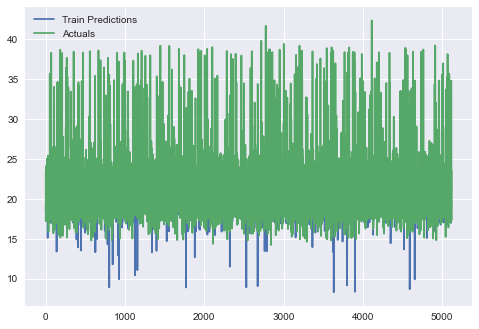

In [37]:
model = load_model('5H_Forecast/5H_ForecastModel_9_SizeWindow/')

X, y = DataHandler(5,9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])

### 6 hours forecast

In [32]:
%%time

Trainer(6,6,9)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
161/161 [==============================] - 5s 16ms/step - loss: 511.0100 - mean_absolute_error: 22.1505 - val_loss: 284.0171 - val_mean_absolute_error: 16.8024
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 2s 13ms/step - loss: 446.7068 - mean_absolute_error: 20.6270 - val_loss: 232.4479 - val_mean_absolute_error: 15.1660
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 8ms/step - loss: 369.5607 - mean_absolute_error: 18.6241 - val_loss: 168.0508 - val_mean_absolute_error: 12.8252
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 9ms/step - loss: 270.2526 - mean_absolute_error: 15.7258 - val_loss: 97.6498 - val_mean_absolute_error: 9.7000
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 2s 9ms/step - loss: 187.1217 - mean_absolute_error: 12.8100 - val_loss: 48.7281 - val_mean_absolute_error: 6.7527
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 7ms/step - loss: 121.2750 - mean_absolute_error: 9.9212 - val_loss: 19.2915 - val_mean_absolute_error: 4.1253
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 7ms/step - loss: 80.4283 - mean_absolute_error: 7.5993 - val_loss: 5.7169 - val_mean_absolute_error: 2.0548
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
161/161 [==============================] - 1s 7ms/step - loss: 54.3480 - mean_absolute_error: 5.6166 - val_loss: 1.8296 - val_mean_absolute_error: 1.0879
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
161/161 [==============================] - 1s 7ms/step - loss: 36.8180 - mean_absolute_error: 4.0049 - val_loss: 4.2884 - val_mean_absolute_error: 1.7039
Epoch 10/25
161/161 [==============================] - 1s 7ms/step - loss: 27.1471 - mean_absolute_error: 3.1356 - val_loss: 8.4008 - val_mean_absolute_error: 2.5758
Epoch 11/25
161/161 [==============================] - 1s 7ms/step - loss: 23.2739 - mean_absolute_error: 2.8789 - val_loss: 12.2963 - val_mean_absolute_error: 3.2279
Epoch 12/25
161/161 [==============================] - 1s 7ms/step - loss: 21.5842 - mean_absolute_error: 2.8888 - val_loss: 15.5881 - val_mean_absolute_error: 3.6971
Epoch 13/25
161/161 [==============================] - 1s 7ms/step - loss: 20.8658 - mean_absolute_error: 2.9782 - val_loss: 18.1636 - val_mean_absolute_error: 4.0273
Epoch 14/25
161/161 [==============================] - 1s 7ms/step - loss: 20.5989 - mean_absolute_error: 3.0438 - val_loss: 18.6886 - val_mean_absolute_error: 4.0873
E

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
161/161 [==============================] - 1s 8ms/step - loss: 423.5286 - mean_absolute_error: 20.0999 - val_loss: 216.2709 - val_mean_absolute_error: 14.6351
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
161/161 [==============================] - 1s 9ms/step - loss: 311.4393 - mean_absolute_error: 17.0401 - val_loss: 110.9794 - val_mean_absolute_error: 10.2800
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
161/161 [==============================] - 1s 9ms/step - loss: 179.9237 - mean_absolute_error: 12.4186 - val_loss: 39.6999 - val_mean_absolute_error: 5.9499
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
161/161 [==============================] - 1s 9ms/step - loss: 99.6339 - mean_absolute_error: 8.5995 - val_loss: 8.3481 - val_mean_absolute_error: 2.3771
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
161/161 [==============================] - 1s 8ms/step - loss: 50.9899 - mean_absolute_error: 5.2064 - val_loss: 3.1100 - val_mean_absolute_error: 1.4573
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow\assets


Epoch 7/25
161/161 [==============================] - 1s 8ms/step - loss: 32.2964 - mean_absolute_error: 3.5188 - val_loss: 8.5754 - val_mean_absolute_error: 2.5193
Epoch 8/25
161/161 [==============================] - 1s 8ms/step - loss: 25.4165 - mean_absolute_error: 3.0079 - val_loss: 13.1355 - val_mean_absolute_error: 3.3126
Epoch 9/25
161/161 [==============================] - 1s 8ms/step - loss: 22.7549 - mean_absolute_error: 2.9432 - val_loss: 15.7512 - val_mean_absolute_error: 3.7057
Epoch 10/25
161/161 [==============================] - 1s 9ms/step - loss: 20.8019 - mean_absolute_error: 2.8953 - val_loss: 14.8944 - val_mean_absolute_error: 3.6253
Epoch 11/25
161/161 [==============================] - 1s 8ms/step - loss: 19.0245 - mean_absolute_error: 2.7751 - val_loss: 16.1257 - val_mean_absolute_error: 3.7610
Epoch 12/25
161/161 [==============================] - 1s 8ms/step - loss: 17.9334 - mean_absolute_error: 2.7571 - val_loss: 16.9009 - val_mean_absolute_error: 3.8651
Ep

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
160/160 [==============================] - 1s 8ms/step - loss: 478.5885 - mean_absolute_error: 21.4478 - val_loss: 269.6496 - val_mean_absolute_error: 16.3474
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
160/160 [==============================] - 1s 8ms/step - loss: 409.9576 - mean_absolute_error: 19.7841 - val_loss: 214.7224 - val_mean_absolute_error: 14.5760
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
160/160 [==============================] - 1s 9ms/step - loss: 347.3169 - mean_absolute_error: 18.1174 - val_loss: 167.4034 - val_mean_absolute_error: 12.8468
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
160/160 [==============================] - 1s 8ms/step - loss: 282.2964 - mean_absolute_error: 16.2176 - val_loss: 120.6298 - val_mean_absolute_error: 10.8753
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
160/160 [==============================] - 1s 8ms/step - loss: 229.8299 - mean_absolute_error: 14.4722 - val_loss: 86.6856 - val_mean_absolute_error: 9.2202
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
160/160 [==============================] - 1s 8ms/step - loss: 193.9442 - mean_absolute_error: 13.1470 - val_loss: 65.1777 - val_mean_absolute_error: 7.9807
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
160/160 [==============================] - 1s 8ms/step - loss: 166.6299 - mean_absolute_error: 12.0454 - val_loss: 47.9475 - val_mean_absolute_error: 6.8267
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
160/160 [==============================] - 1s 8ms/step - loss: 141.4757 - mean_absolute_error: 10.9738 - val_loss: 35.9889 - val_mean_absolute_error: 5.8877
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
160/160 [==============================] - 1s 8ms/step - loss: 122.2089 - mean_absolute_error: 10.0679 - val_loss: 26.6403 - val_mean_absolute_error: 5.0317
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
160/160 [==============================] - 1s 8ms/step - loss: 106.0024 - mean_absolute_error: 9.2269 - val_loss: 19.0119 - val_mean_absolute_error: 4.2060
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
160/160 [==============================] - 1s 8ms/step - loss: 91.3348 - mean_absolute_error: 8.3948 - val_loss: 12.6504 - val_mean_absolute_error: 3.3592
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
160/160 [==============================] - 1s 8ms/step - loss: 77.2625 - mean_absolute_error: 7.5165 - val_loss: 7.5760 - val_mean_absolute_error: 2.5148
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
160/160 [==============================] - 1s 8ms/step - loss: 64.8122 - mean_absolute_error: 6.6686 - val_loss: 4.1387 - val_mean_absolute_error: 1.7739
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
160/160 [==============================] - 1s 8ms/step - loss: 53.5304 - mean_absolute_error: 5.7489 - val_loss: 2.0372 - val_mean_absolute_error: 1.1698
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
160/160 [==============================] - 1s 8ms/step - loss: 44.2049 - mean_absolute_error: 4.8633 - val_loss: 1.3458 - val_mean_absolute_error: 0.8782
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow\assets


Epoch 17/25
160/160 [==============================] - 1s 8ms/step - loss: 37.7963 - mean_absolute_error: 4.2001 - val_loss: 1.9437 - val_mean_absolute_error: 1.0971
Epoch 18/25
160/160 [==============================] - 1s 8ms/step - loss: 32.9901 - mean_absolute_error: 3.6951 - val_loss: 3.2417 - val_mean_absolute_error: 1.5173
Epoch 19/25
160/160 [==============================] - 1s 8ms/step - loss: 29.3179 - mean_absolute_error: 3.3178 - val_loss: 5.0381 - val_mean_absolute_error: 1.9812
Epoch 20/25
160/160 [==============================] - 1s 8ms/step - loss: 26.5516 - mean_absolute_error: 3.0640 - val_loss: 7.1493 - val_mean_absolute_error: 2.4343
Epoch 21/25
160/160 [==============================] - 1s 8ms/step - loss: 24.5374 - mean_absolute_error: 2.9058 - val_loss: 9.4004 - val_mean_absolute_error: 2.8478
Epoch 22/25
160/160 [==============================] - 1s 7ms/step - loss: 23.1311 - mean_absolute_error: 2.8321 - val_loss: 11.5880 - val_mean_absolute_error: 3.2020
Epo

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
160/160 [==============================] - 1s 9ms/step - loss: 438.2145 - mean_absolute_error: 20.4052 - val_loss: 224.7077 - val_mean_absolute_error: 14.9351
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
160/160 [==============================] - 1s 9ms/step - loss: 360.3276 - mean_absolute_error: 18.4340 - val_loss: 165.4303 - val_mean_absolute_error: 12.7676
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
160/160 [==============================] - 1s 9ms/step - loss: 273.3515 - mean_absolute_error: 15.8886 - val_loss: 107.1524 - val_mean_absolute_error: 10.1745
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
160/160 [==============================] - 2s 11ms/step - loss: 198.7802 - mean_absolute_error: 13.3307 - val_loss: 63.6543 - val_mean_absolute_error: 7.8174
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 6/25
160/160 [==============================] - 1s 9ms/step - loss: 146.8945 - mean_absolute_error: 11.2055 - val_loss: 33.1976 - val_mean_absolute_error: 5.6202
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 7/25
160/160 [==============================] - 2s 10ms/step - loss: 108.4745 - mean_absolute_error: 9.3178 - val_loss: 16.5785 - val_mean_absolute_error: 3.8713
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
160/160 [==============================] - 1s 9ms/step - loss: 81.4476 - mean_absolute_error: 7.7342 - val_loss: 7.4877 - val_mean_absolute_error: 2.4685
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
160/160 [==============================] - 2s 10ms/step - loss: 62.9784 - mean_absolute_error: 6.4286 - val_loss: 2.6882 - val_mean_absolute_error: 1.3772
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 10/25
160/160 [==============================] - 2s 10ms/step - loss: 48.0977 - mean_absolute_error: 5.1376 - val_loss: 1.4497 - val_mean_absolute_error: 0.9342
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow\assets


Epoch 11/25
160/160 [==============================] - 1s 9ms/step - loss: 38.4381 - mean_absolute_error: 4.1720 - val_loss: 2.5340 - val_mean_absolute_error: 1.2953
Epoch 12/25
160/160 [==============================] - 2s 9ms/step - loss: 31.5433 - mean_absolute_error: 3.4422 - val_loss: 5.3534 - val_mean_absolute_error: 2.0545
Epoch 13/25
160/160 [==============================] - 1s 9ms/step - loss: 26.3697 - mean_absolute_error: 3.0104 - val_loss: 9.5896 - val_mean_absolute_error: 2.8795
Epoch 14/25
160/160 [==============================] - 2s 10ms/step - loss: 22.7956 - mean_absolute_error: 2.8242 - val_loss: 12.2896 - val_mean_absolute_error: 3.3098
Epoch 15/25
160/160 [==============================] - 1s 9ms/step - loss: 21.5186 - mean_absolute_error: 2.8402 - val_loss: 14.7558 - val_mean_absolute_error: 3.6639
Epoch 16/25
160/160 [==============================] - 1s 9ms/step - loss: 20.8028 - mean_absolute_error: 2.8917 - val_loss: 16.4587 - val_mean_absolute_error: 3.8941


In [33]:
%%time

modelsEvaluator(6,6,9)

(5121, 6, 5) (5121,) (1707, 6, 5) (1707,) (1708, 6, 5) (1708,)
Loading: 6H_Forecast/6H_ForecastModel_6_SizeWindow/
54/54 [==============================] - 1s 2ms/step - loss: 35.0863 - mean_absolute_error: 4.2176
(5121, 7, 5) (5121,) (1707, 7, 5) (1707,) (1707, 7, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_7_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 30.1240 - mean_absolute_error: 3.7998
(5120, 8, 5) (5120,) (1707, 8, 5) (1707,) (1707, 8, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_8_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 30.2994 - mean_absolute_error: 3.9242
(5119, 9, 5) (5119,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_9_SizeWindow/
54/54 [==============================] - 1s 3ms/step - loss: 34.7516 - mean_absolute_error: 4.1656
CPU times: total: 50.3 s
Wall time: 37.2 s


54/54 [==============================] - 1s 3ms/step - loss: 28.3605 - mean_absolute_error: 3.6598


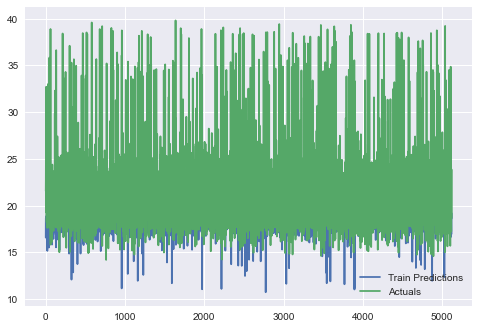

In [38]:
model = load_model('6H_Forecast/6H_ForecastModel_7_SizeWindow/')

X, y = DataHandler(6,7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25) 
model.evaluate(X_test,y_test)

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

pd.concat([train_results['Train Predictions'],train_results['Actuals']],axis=1).plot()
plt.legend(['Train Predictions','Actuals'])